# TP1: 

Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Chargement de la base en mémoire

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Téléchargement de la base d'entraînement

In [2]:
import dataset_loader
import pickle
train_set, valid_set, test_set = dataset_loader.load_mnist()
#pickle.dump(train_set,open("train_set.save.p","wb"))
#pickle.dump(test_set,open("test_set.save.p","wb"))
#pickle.dump(valid_set,open("valid_set.save.p","wb"))

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 4


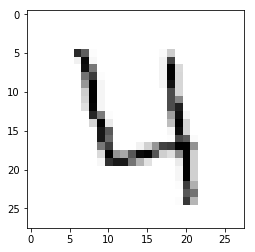

In [3]:
img_id = 900
X=train_set[0][img_id]
plt.imshow(X.reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

Question 1: Donner les caractéristiques de la base d'apprentissage train_set

In [4]:
def getDimDataset(train_set):
    n_training = len(train_set[0])
    n_feature = len(train_set[0][0])
    n_label = len(set(train_set[1]))
    return n_training, n_feature, n_label

(n_training,n_feature,n_label)=getDimDataset(train_set)
print (n_training,n_feature,n_label)

(50000, 784, 10)


## Création du modèle

In [5]:
def init(n_feature,n_label):
    sigma = 1.
    W = np.random.normal(loc=0.0, scale=sigma/np.sqrt(n_feature), size=(n_label,n_feature))
    b = np.zeros((W.shape[0],1))
    return W,b

W,b=init(n_feature,n_label)

Question 2: Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [6]:
def printInfo(W,b):
    print("W dimensions: " + str(W.shape))
    print("b dimensions: " + str(b.shape))
    print("Number of parameters: " + str(W.shape[0]*W.shape[1]+b.shape[0]))
    
printInfo(W,b)

W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850


Question 3: Implémenter la fonction forward $$z_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le bias associé à l'unité $j$

In [7]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights
        :param b: the bias
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values
        :rtype: ndarray
    """
    #print('forward : X', X.shape, 'W', W.shape, 'b', b.shape)
    z = X.dot(W.transpose()) + b.transpose()
    return z

#X = train_set[0][:5] # 5 examples at once
#print(X.shape)
z = forward(W,b,X) # Works with any number of examples !
#print(z.shape)
#print(z)

Question 4: Implémenter la fonction softmax $$ \sigma_i = P(t=i|x,W,b) = \frac{\exp{z_i}}{\sum_k \exp{z_k}}$$

In [8]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    exps = np.exp(z-np.max(z,axis=1).reshape(-1,1))
    somme_exps = np.sum(exps,axis=1)
    for i in range(somme_exps.shape[0]):
        exps[i]/=somme_exps[i]
    return exps
out=softmax(z)
#print(out.shape)
#print (out)

Optionnel: Vérifier que votre implémentation de softmax soit numériquement stable (cf. http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression)

In [9]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
my_z = np.array([1000000,1,100]).reshape(1,3)
print (my_z)
print(softmax(my_z))

[[1000000       1     100]]
[[ 1.  0.  0.]]


Question 5: Implémenter le calcul du gradient de l'erreur par rapport à $z_i$:
$$\delta z_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [10]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z
    :rtype: ndarray
    """
    #print('gradient_out : out', out.shape, 'one_hot_batch', one_hot_batch.shape)
    return out - one_hot_batch

derror=gradient_out(out,np.array([0,0,0,0,0,0,0,0,1,0]))
#print(derror.shape)
#print(derror)

Question 6: Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta z_j x_i$$  $$\delta b_{j} = \delta z_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [11]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z
        :param X: the input (minibatch_size x n_input)
        :param minibatch_size: the minibatch size
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: the gradient w.r.t. the parameters
        :rtype: ndarray, ndarray
    """     
    grad_b = derror
    grad_w = derror.transpose().dot(X.reshape(-1, 784))
    #print('gradient_update: grad_w', grad_w.shape, 'grad_b', grad_b.shape)
    return grad_w,grad_b

#print(derror.shape)
grad_w, grad_b=gradient(derror,X)
#print(grad_w.shape, grad_b.shape)
#print(grad_w)
#print(grad_b)

Question 7: Implémenter la fonction de mise à jour des paramètres $$p = p - \eta \delta p$$ où $p$ est un paramètre du modèle et $\delta p$ la composante du gradient associée à p.

In [12]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    b = b.transpose()
    b = b - eta*grad_b
    W = W - eta*grad_w
    #print('update : W', W.shape, 'b', b.shape, 'grad_w', grad_w.shape, 'grad_b', grad_b.shape)
    return W, b
eta=0.1
#print(W.shape, b.shape)
#print(b)
W,b=update(eta, W, b, grad_w, grad_b)
#print(b)

Question 8: Implémenter la fonction de calcul du coût et de la précision:
Utiliser les fonction *forward* et *softmax*, puis calculer le coût $c$, qui est moins la log-probabilité des classes à prédire: $$c = - \sum_{(x_{i}, y_{i}) \in \mathcal{D}} \log P(y=y_{i}|x_{i},W,b)$$

Et enfin la précision, c'est à dire le taux de prédictions réussies.

In [13]:
def computeLoss(W, b, batch, labels, softmax):
    """
        Compute the loss value of the current network on the full batch
        :param W: the weights
        :param B: the bias
        :param batch: the weights
        :param labels: the bias
        :param act_func: the weights
        :type W: ndarray
        :type B: ndarray
        :type batch: ndarray
        :type act_func: function
        :return loss: the negative log-likelihood
        :return accuracy: the ratio of examples that are well-classified
        :rtype: float
        :rtype: float
    """ 
    #print('computeLoss: W', W.shape, 'b', b.shape, 'batch', batch.shape, 'labels', labels.shape)
    ### Forward propagation
    z = forward(W,b[:,0:1],batch)
    ### Compute the softmax
    out=softmax(z)
    
    loss = -np.sum(np.log(out[np.arange(out.shape[0]), labels]))
    accuracy = np.mean((np.argmax(out, axis=1) == labels).astype(np.float, copy=False))
    return loss, accuracy

Question 9: Implémenter la fonction de création de mini-batch, qui pour un indice, une taille de batch, des données d'entraînement et les labels correspondants, renvoie le batch de données/labels correspondant, et la taille du batch. 

In [14]:
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
        Return a minibatch from the training set and the associated labels
        :param i: the identifier of the minibatch
        :param batch_size: the number of training examples
        :param train_set: the training set
        :param one_hot: the one-hot representation of the labels
        :type i: int
        :type batch_size: int
        :type train_set: ndarray
        :type ont_hot: ndarray
        :return: the minibatch of examples
        :return: the minibatch of labels
        :return: the number of examples in the minibatch
        :rtype: ndarray
        :rtype: ndarray
        :rtype: int
    """
    idx_begin = i
    idx_end = i+batch_size
    batch = train_set[0][idx_begin:idx_end]
    one_hot=one_hot.transpose()
    one_hot_batch = one_hot[idx_begin:idx_end,:]
    mini_batch_size = batch.shape[0]

    return np.asfortranarray(batch), one_hot_batch, mini_batch_size



## Algorithme d'apprentissage

In [15]:
import math,time, pickle
from IPython.display import clear_output


#train_set=pickle.load(open("train_set.save.p","rb"))
#test_set=pickle.load(open("test_set.save.p","rb"))
#valid_set=pickle.load(open("valid_set.save.p","rb"))

# Data structures for plotting

n_training, n_feature, n_label = getDimDataset(train_set)

# SGD parameters
etas=[0.0001,0.001,0.01,0.1,1.0,10.]
#etas=[0.0001,0.001,0.01]
batch_size = 500
n_batch = int(math.ceil(float(n_training)/batch_size))
n_epoch = 25



# Initialize the model parameters
W,b = init(n_feature,n_label)
printInfo(W,b)

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.

g_train_losses=[]
g_valid_losses=[]
g_train_accuracies=[]
g_valid_accuracies=[]

for eta in etas:
    print ("ETA="+str(eta)+"\n-----------------------------")
    cumul_time = 0.
    g_train_loss=[]
    g_train_acc=[]
    g_valid_loss=[]
    g_valid_acc=[]
    
    for i in range(n_epoch):
        
        for j in range(n_batch):

            ### Mini-batch creation
            minibatch, one_hot_batch, minibatch_size = getMiniBatch(j, batch_size, train_set, one_hot)
            #print('mini batch', minibatch.shape)
            #print('one-hot batch', one_hot_batch.shape)

            prev_time = time.clock()

            ### Forward propagation
            Z = forward(W,b,minibatch)

            ### Compute the softmax
            out = softmax(Z)

            ### Compute the gradient at the top layer
            derror = gradient_out(out,one_hot_batch)

            ### Compute the gradient w.r.t. parameters
            grad_w,grad_b = gradient(derror, minibatch)

            ### Update the parameters
            W,b = update(eta, W, b, grad_w, grad_b)
            b = b.transpose()

            curr_time = time.clock()
            cumul_time += curr_time - prev_time

        ### Training accuracy
        train_loss, train_acc = computeLoss(W, b, train_set[0], train_set[1],softmax) 

        ### Valid accuracy
        valid_loss, valid_acc = computeLoss(W, b, valid_set[0], valid_set[1],softmax) 

        g_train_loss.append(train_loss)
        g_train_acc.append(train_acc)
        g_valid_loss.append(valid_loss)
        g_valid_acc.append(valid_acc)
        
        result_line = "Iter" + str(i) + ", training time: " + str(round(cumul_time, 2)) + "s, Tloss=" + str(round(train_loss, 2)) + ", Taccu=" + str(round(train_acc, 4)) + ", Vloss=" + str(round(valid_loss, 2)) + ", Vaccu=" + str(round(valid_acc, 4))
        print(result_line)
        print("-------------------------------------------")
    
    g_train_losses.append(g_train_loss)
    g_valid_losses.append(g_valid_loss)
    g_train_accuracies.append(g_train_acc)
    g_valid_accuracies.append(g_valid_acc)


W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
ETA=0.0001
-----------------------------
Iter0, training time: 0.8s, Tloss=42707.39, Taccu=0.8053, Vloss=8064.19, Vaccu=0.8266
-------------------------------------------
Iter1, training time: 1.45s, Tloss=33788.0, Taccu=0.8276, Vloss=6258.8, Vaccu=0.8486
-------------------------------------------
Iter2, training time: 2.06s, Tloss=30359.58, Taccu=0.8366, Vloss=5579.23, Vaccu=0.8575
-------------------------------------------
Iter3, training time: 2.69s, Tloss=28531.0, Taccu=0.8412, Vloss=5221.92, Vaccu=0.8623
-------------------------------------------
Iter4, training time: 3.26s, Tloss=27400.64, Taccu=0.8445, Vloss=5003.38, Vaccu=0.8658
-------------------------------------------
Iter5, training time: 3.86s, Tloss=26642.61, Taccu=0.8462, Vloss=4858.04, Vaccu=0.8674
-------------------------------------------
Iter6, training time: 4.47s, Tloss=26108.51, Taccu=0.8476, Vloss=4756.31, Vaccu=0.8673
-------------

Iter11, training time: 7.47s, Tloss=36851.37, Taccu=0.8464, Vloss=6679.05, Vaccu=0.8575
-------------------------------------------
Iter12, training time: 8.07s, Tloss=37119.51, Taccu=0.8463, Vloss=6728.61, Vaccu=0.8574
-------------------------------------------
Iter13, training time: 8.68s, Tloss=37372.24, Taccu=0.8463, Vloss=6775.37, Vaccu=0.8573
-------------------------------------------
Iter14, training time: 9.27s, Tloss=37611.29, Taccu=0.8462, Vloss=6819.64, Vaccu=0.8573
-------------------------------------------
Iter15, training time: 9.9s, Tloss=37838.11, Taccu=0.846, Vloss=6861.67, Vaccu=0.8572
-------------------------------------------
Iter16, training time: 10.52s, Tloss=38053.9, Taccu=0.8459, Vloss=6901.69, Vaccu=0.8569
-------------------------------------------
Iter17, training time: 11.15s, Tloss=38259.73, Taccu=0.8457, Vloss=6939.89, Vaccu=0.8568
-------------------------------------------
Iter18, training time: 11.77s, Tloss=38456.48, Taccu=0.8455, Vloss=6976.42, V

Iter23, training time: 14.62s, Tloss=60093.22, Taccu=0.8418, Vloss=10957.06, Vaccu=0.8514
-------------------------------------------
Iter24, training time: 15.21s, Tloss=60266.48, Taccu=0.8418, Vloss=10989.33, Vaccu=0.8515
-------------------------------------------
ETA=10.0
-----------------------------
Iter0, training time: 0.64s, Tloss=61757.41, Taccu=0.842, Vloss=11256.72, Vaccu=0.8522
-------------------------------------------
Iter1, training time: 1.25s, Tloss=62856.6, Taccu=0.8419, Vloss=11458.85, Vaccu=0.8519
-------------------------------------------
Iter2, training time: 1.84s, Tloss=63745.89, Taccu=0.8418, Vloss=11622.7, Vaccu=0.8515
-------------------------------------------
Iter3, training time: 2.42s, Tloss=64493.94, Taccu=0.8416, Vloss=11760.46, Vaccu=0.8513
-------------------------------------------
Iter4, training time: 3.02s, Tloss=65139.85, Taccu=0.8415, Vloss=11879.35, Vaccu=0.8512
-------------------------------------------
Iter5, training time: 3.66s, Tloss=6

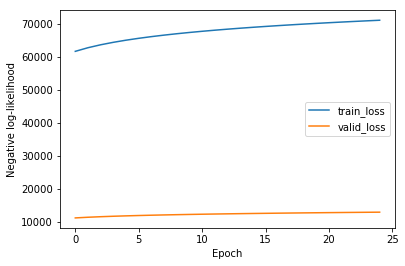

In [16]:
plt.plot(np.arange(len(g_train_loss)),g_train_loss,label='train_loss')
plt.plot(np.arange(len(g_valid_loss)),g_valid_loss,label='valid_loss')
plt.xlabel("Epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

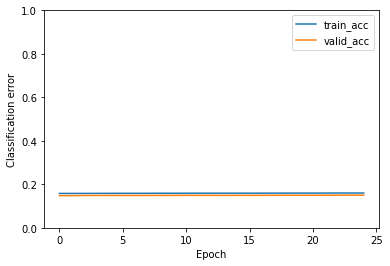

In [17]:
plt.plot(np.arange(len(g_train_acc)),1.0-np.array(g_train_acc),label='train_acc')
plt.plot(np.arange(len(g_valid_acc)),1.0-np.array(g_valid_acc),label='valid_acc')
plt.xlabel("Epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()

Question 10: Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage

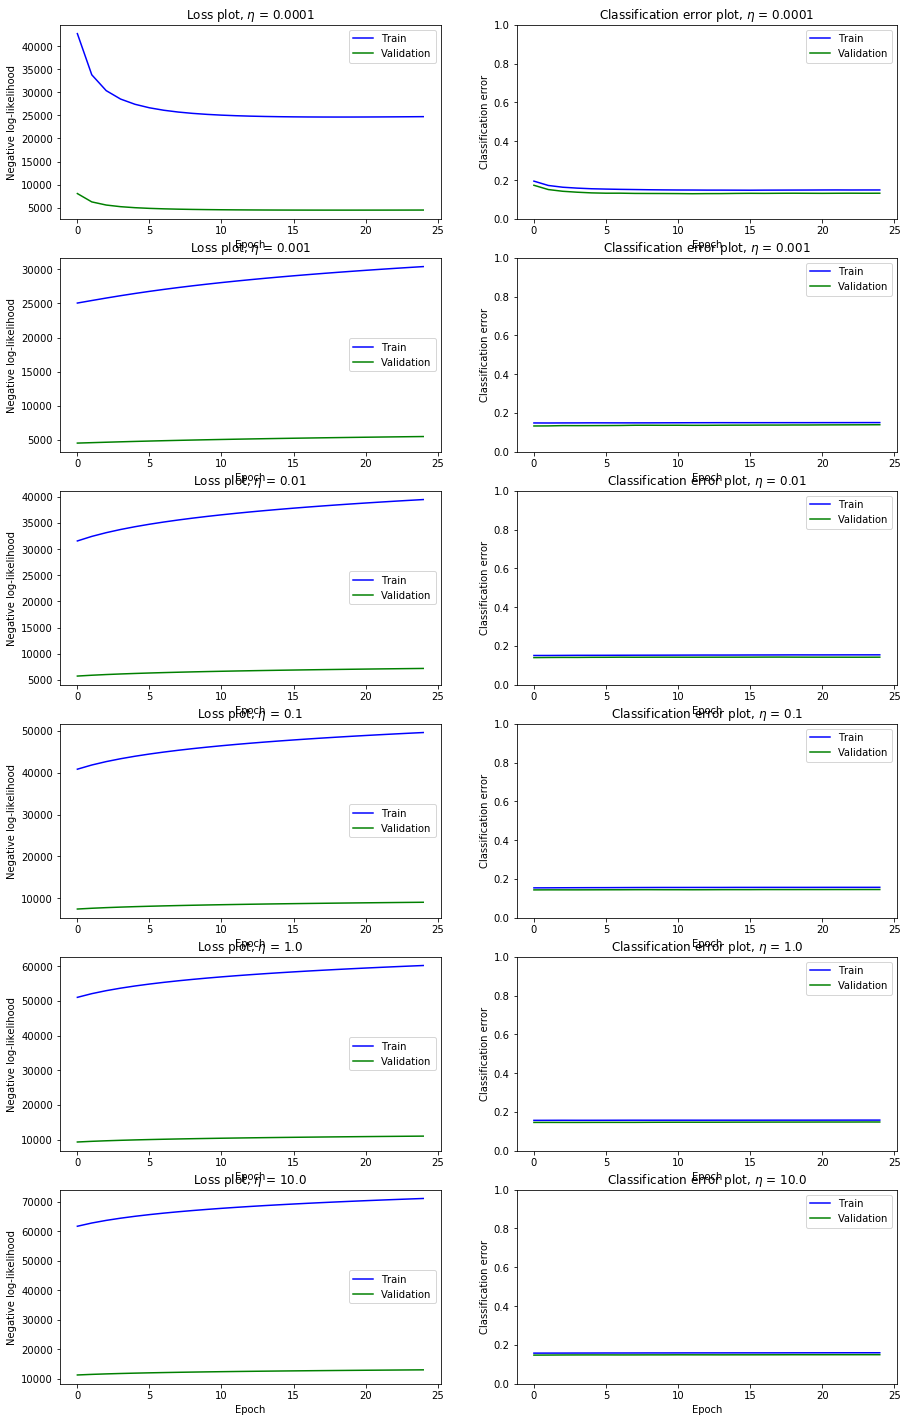

In [18]:
horizontal_positions = 2
vertical_positions = len(etas)
plt.figure(figsize=(15, 25))
for i in range(len(etas)):
    plt.subplot(vertical_positions, horizontal_positions, 2*i+1)
    plt.plot(np.arange(len(g_train_losses[i])),g_train_losses[i], label='Train', color='blue')
    plt.plot(np.arange(len(g_valid_losses[i])),g_valid_losses[i], label='Validation', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Negative log-likelihood")
    plt.title('Loss plot, $\eta$ = '+str(etas[i]))
    plt.legend()
    plt.subplot(vertical_positions, horizontal_positions, 2*i+2)
    plt.ylim([0.,1.])
    plt.plot(np.arange(len(g_train_accuracies[i])),1-np.array(g_train_accuracies[i]), label='Train', color='blue')
    plt.plot(np.arange(len(g_valid_accuracies[i])),1-np.array(g_valid_accuracies[i]), label='Validation', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Classification error")
    plt.title('Classification error plot, $\eta$ = '+str(etas[i]))
    plt.legend()